In [1]:
from scipy.io import arff
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from collections import defaultdict
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle
from sklearn.base import clone
from sklearn.model_selection import KFold
from scipy.stats import rankdata

In [2]:
# utility functions
def get_data(data, relevant_params):
    task_ids = data['task_id'].unique()
    data = data.loc[data['kernel'] == b'rbf']
    data = data[relevant_params + ['task_id'] + ['y']]
    data_dict = defaultdict()
    for task_id in task_ids:
        X_task = data.loc[data['task_id'] == task_id]
        y_task = np.array(X_task['y'], dtype=np.float)
        X_task.drop(['y', 'task_id'], 1, inplace=True)
        categorical_names = X_task.select_dtypes(include=['object']).columns
        categorical_ids = [X_task.columns.get_loc(colname) for colname in categorical_names]
        data_dict[task_id] = (X_task.as_matrix(), y_task, categorical_ids)
    return data_dict

def train_model_rs(X, y, ntrees=10):
    param_dist = {'max_depth': np.arange(3, 11),
          'max_features': np.arange(1, 15),
          'n_estimators' : [100],
          'min_samples_split': np.arange(2, 11),
          'bootstrap': [True, False],
          'criterion': ['mse', 'mae']}
    clf = Pipeline(
        steps=[('encoder', sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')),
                ('random search', RandomizedSearchCV(RandomForestRegressor(ntrees), 
                                                     param_distributions=param_dist,
                                                     n_iter=200, cv=5))])
    clf.fit(X, y)
    return clf

def f(x, coeff):
    a, b, c, d, e = coeff
    return a * x[:, 0] + b * x[:, 1] + c * (x[:, 0] ** 2) + d * x[:, 0] * x[:, 1] + e * (x[:, 1] ** 2)

def precatn(task_id, model, X, y, kfolds=5, topn=5, coeff=None):
    kf = KFold(n_splits=kfolds, random_state=42, shuffle=True)
    splits = kf.split(X)
    scores = []
    for train_idx, test_idx in splits:
        train_x, train_y = X[train_idx], y[train_idx]
        test_x, test_y = X[test_idx], y[test_idx]
        if model is not None:
            new_model = clone(model)
            new_model.fit(train_x, train_y)
            y_hat = new_model.predict(test_x)
        else:
            y_hat = f(test_x, coeff)
        y_hat_ranks = rankdata(y_hat, method='average')
        test_y_ranks = rankdata(test_y, method='average')
        y_hat_maxargs = y_hat_ranks.argsort()
        test_y_maxargs = test_y_ranks.argsort()
        cnt = 0
        for entry in y_hat_maxargs[:topn]:
            if entry in test_y_maxargs[:topn]:
                cnt += 1
        scores.append(cnt / topn)
    mean_score = np.mean(scores)
    print('Task %d; Precision at %d Score: %0.4f' %(task_id, topn, mean_score))
    return mean_score

In [3]:
meta_filename = './data/metafeatures.arff'
data_filename = './data/libsvm_svc.arff'
meta, _ = arff.loadarff(meta_filename)
data, _ = arff.loadarff(data_filename)
df_meta = pd.DataFrame(meta)
df_data = pd.DataFrame(data)
relevant_params = ['C', 'gamma']
data_dict = get_data(df_data, relevant_params)

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [4]:
surrogates = pickle.load(open('/Users/prernakashyap/Documents/autoML research/models/ssm1.pkl', 'rb'))
metamodel = pickle.load(open('/Users/prernakashyap/Documents/autoML research/models/mm1.pkl', 'rb'))

In [5]:
model_params = defaultdict(list)
task_ids = list(data_dict.keys())
task_ids.remove(34536.0)
for task_id in task_ids:
    params = surrogates[task_id].coef_
    model_params['a'].append(params[0]) #C
    model_params['b'].append(params[1]) #gamma
    model_params['c'].append(params[2]) #C^2
    model_params['d'].append(params[3]) #C.gamma
    model_params['e'].append(params[4]) #gamma^2
df_model_params = pd.DataFrame(model_params)

In [6]:
y = df_model_params.as_matrix() #shape: (99,5)
X = df_meta.as_matrix() #shape: (99, 19)

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
# clf = train_model_rs(X, y)

In [13]:
params = metamodel.predict(X) #shape=(99, 5)
surrogate_scores = []
metamodel_scores = []
for i, task_id in enumerate(task_ids):
    X_task, y_task, _ = data_dict[task_id]
    surrogate_params = surrogates[task_id].coef_
    metamodel_params = params[i]
    print('Surrogate params:', surrogate_params)
    print('Metamodel params:', metamodel_params)
    surrogate_scores.append(precatn(task_id, surrogates[task_id], X_task, y_task, topn=10))
    metamodel_scores.append(precatn(task_id, model=None, X=X_task, y=y_task, topn=10, coeff=(metamodel_params)))

Surrogate params: [ 7.45343067e-06 -2.69039933e-01 -2.25645674e-10  9.12993402e-07
  3.19692555e-02]
Metamodel params: [ 4.37368886e-06 -9.02145317e-02 -2.41373834e-09  1.38550186e-05
  1.02571699e-02]
Task 3; Precision at 10 Score: 0.7600
Task 3; Precision at 10 Score: 0.6200
Surrogate params: [ 2.38643065e-05  1.88423355e-02 -7.02332387e-10 -5.88374584e-07
 -9.85047272e-03]
Metamodel params: [ 3.11738803e-06 -3.05479315e-02 -9.06183430e-11 -1.53827647e-07
  2.56156305e-03]
Task 6; Precision at 10 Score: 0.3200
Task 6; Precision at 10 Score: 0.3200
Surrogate params: [ 9.82281264e-06 -2.92412298e-02 -3.19073754e-10  3.53084674e-07
  9.38497126e-04]
Metamodel params: [ 2.29639514e-06 -3.89985446e-02 -6.60899700e-11 -9.72598981e-08
  3.94464872e-03]
Task 11; Precision at 10 Score: 0.5200
Task 11; Precision at 10 Score: 0.5600
Surrogate params: [ 1.12113894e-05 -5.23059456e-01 -1.60568641e-10 -1.30803627e-06
  6.92412114e-02]
Metamodel params: [ 7.48194916e-06 -1.92082666e-01 -2.87005402e

Task 3904; Precision at 10 Score: 0.5400
Surrogate params: [-2.87865689e-06 -2.62925020e-02  7.35363090e-11  7.83353656e-07
  3.16810541e-03]
Metamodel params: [ 1.69996950e-06 -2.47636722e-02 -4.94756945e-11 -8.19479770e-08
  2.34485984e-03]
Task 3913; Precision at 10 Score: 0.7000
Task 3913; Precision at 10 Score: 0.6400
Surrogate params: [-7.69524434e-07 -3.45558076e-03  2.60208613e-11 -1.25261010e-08
  3.77271213e-04]
Metamodel params: [ 1.69996950e-06 -2.47636722e-02 -4.94756945e-11 -8.19479770e-08
  2.34485984e-03]
Task 3917; Precision at 10 Score: 0.6000
Task 3917; Precision at 10 Score: 0.5200
Surrogate params: [ 8.86692228e-08  2.60389013e-03 -2.42670951e-12  7.21892380e-09
 -2.22413645e-04]
Metamodel params: [ 1.69888928e-06 -2.45610029e-02 -4.93620266e-11 -8.15276623e-08
  2.31719382e-03]
Task 3918; Precision at 10 Score: 0.1600
Task 3918; Precision at 10 Score: 0.4000
Surrogate params: [0. 0. 0. 0. 0.]
Metamodel params: [ 1.93145190e-06 -2.69122916e-02 -5.51989444e-11 -3.69

Task 14965; Precision at 10 Score: 0.8200
Task 14965; Precision at 10 Score: 0.7800
Surrogate params: [-8.65619872e-07 -1.20284488e-01  4.14951664e-11 -4.76780303e-07
  1.66194414e-02]
Metamodel params: [ 1.94887390e-06 -4.12827981e-02 -5.65738606e-11 -1.43119106e-07
  4.59805954e-03]
Task 14966; Precision at 10 Score: 0.9400
Task 14966; Precision at 10 Score: 0.9400
Surrogate params: [ 1.51329448e-06 -1.03203766e-01 -3.80487498e-11 -7.88709995e-07
  1.11685078e-02]
Metamodel params: [ 2.48612412e-06 -3.66346314e-02 -7.12801438e-11 -1.60349391e-07
  3.46721833e-03]
Task 14967; Precision at 10 Score: 0.9200
Task 14967; Precision at 10 Score: 0.9400
Surrogate params: [ 4.35376446e-06 -1.31110199e-01 -9.21668527e-11 -3.77378546e-07
  1.80332960e-02]
Metamodel params: [ 2.64038719e-06 -4.79721656e-02 -8.90544072e-11 -6.63515552e-08
  5.44577321e-03]
Task 14968; Precision at 10 Score: 0.9200
Task 14968; Precision at 10 Score: 0.9400
Surrogate params: [ 1.46308962e-06  1.18822331e-03 -5.0054

In [10]:
def draw_plot(data, offset,edge_color, fill_color):
    pos = np.arange(1) + offset 
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

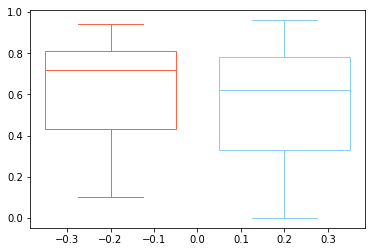

In [14]:
fig, ax = plt.subplots()
draw_plot(surrogate_scores, -0.2, 'tomato', 'white')
draw_plot(metamodel_scores, +0.2, 'skyblue', 'white')
plt.show()
plt.close()

- DT of depth 1-5
- precision at 100 for random forest
- print out RF and see results

In [53]:
lens = []
for task_id in task_ids:
    lens.append(len(data_dict[task_id][0]))
print(np.mean(lens))

166.3838383838384
